# Paths and imports handling

In [1]:
import sys
sys.path.insert(0, "..")

from src.path_handling import resolve_path

All relative paths in resolve_path are considered as relative to PROJECT_ROOT directory


# Import necessary libraries

In [2]:
# Import necessary libraries
import os
import sys
import random
from pathlib import Path

import pandas as pd
import numpy as np
import torch
import lightning as L
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem

from src.chemdata.fingerprints import AvalonFingerprint
from src.chemdata.splits import load_split_info
from src.models.torch_mlp import MLP, Pipeline, run_mlp_hp_search
from src.models.metrics import (
        collect_latents, 
        get_mean_cov_scipy, 
        mahalanobis_batch, 
        cvm_test_chi2, 
        chi2_threshold, 
        rejection_rate_scipy, 
        plot_mahalanobis_distributions,
        parity_plot,
    )
from src.ga.ga_engine import run_ga, predict_logp, plot_logp_comparison

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


# Set seeds

In [4]:
# Set seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
L.seed_everything(42)

Seed set to 42


42

# Load data

In [5]:
# Load data
data_path = resolve_path("./data/logP_dataset.csv")
data = pd.read_csv(data_path, names=["smiles", "logp"])
print(data)

                                            smiles  logp
0                            C[C@H]([C@@H](C)Cl)Cl   2.3
1                                        C(C=CBr)N   0.3
2                                        CCC(CO)Br   1.3
3      [13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O   2.0
4                                          CCCOCCP   0.6
...                                            ...   ...
14605                                    CCC(SC)Br   2.7
14606                    [2H]C([2H])([C@@H](CO)O)O  -1.8
14607                                     CC(C)NNC   0.4
14608                              C[C@H]1CCC[CH]1   3.4
14609                                   [CH]OC(F)F   1.0

[14610 rows x 2 columns]


# Replace logp with rdkit predictions

(check notebook 01 if you want to know why)

In [6]:
from rdkit.Chem.Crippen import MolLogP

def get_rdkit_logp(smi):
    mol = Chem.MolFromSmiles(smi)
    rdkit_logp = MolLogP(mol)
    return rdkit_logp

data["logp"] = data["smiles"].apply(get_rdkit_logp).values

# Convert to Avalon fingerprints

In [7]:
# Convert to Avalon fingerprints
print("Converting SMILES to Avalon fingerprints...")
X_fp = AvalonFingerprint(smiles=data["smiles"]).to_fps()
X_fp = torch.tensor(X_fp, dtype=torch.float32)

Converting SMILES to Avalon fingerprints...
converting data to AvalonFingerprint...


100%|██████████| 14610/14610 [00:08<00:00, 1669.21it/s]


# Load splits

In [8]:
# Load splits
split_info = load_split_info(
    resolve_path("./data/random_split_info.json")
)
print(f"Train: {len(split_info['train'])}, Val: {len(split_info['val'])}, Test: {len(split_info['test'])}")

Train: 11688, Val: 1461, Test: 1461


# Prepare data

In [9]:
# Prepare data
y = torch.tensor(data["logp"].values, dtype=torch.float32)

# Normalize target

In [10]:
# Normalize target
y_train_mean = y[split_info["train"]].mean()
y_train_std = y[split_info["train"]].std()
eps = 1e-8

transform = lambda y: (y - y_train_mean) / (y_train_std + eps)
inv_transform = lambda y_scaled: y_scaled * (y_train_std + eps) + y_train_mean

# Create datasets

In [11]:
# Create datasets
datasets = {
    "train": TensorDataset(X_fp[split_info["train"]], transform(y[split_info["train"]])),
    "val": TensorDataset(X_fp[split_info["val"]], transform(y[split_info["val"]])),
    "test": TensorDataset(X_fp[split_info["test"]], transform(y[split_info["test"]])),
}

train_dataloader = DataLoader(datasets["train"], batch_size=64, shuffle=True)
val_dataloader = DataLoader(datasets["val"], batch_size=256, shuffle=False)
test_dataloader = DataLoader(datasets["test"], batch_size=256, shuffle=False)

# Run hyperparameter search

Here we run hyperparameter search for MLPregressor with such architecture: 

In [12]:
from torchsummary import summary

summary(MLP().to(DEVICE), input_size=(1024,), batch_size=64, device=DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [64, 128]         131,200
              ReLU-2                  [64, 128]               0
           Dropout-3                  [64, 128]               0
            Linear-4                   [64, 64]           8,256
              ReLU-5                   [64, 64]               0
           Dropout-6                   [64, 64]               0
         LayerNorm-7                   [64, 64]             128
            Linear-8                   [64, 32]           2,080
              ReLU-9                   [64, 32]               0
           Linear-10                    [64, 1]              33
Total params: 141,697
Trainable params: 141,697
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 0.34
Params size (MB): 0.54
Estimated T

Hyperparameters are:  

for MLP model itself:  
dropout_prob: [0.0, 0.1, 0.2], float  

and for optimizer (adam):  
weight_decay: [1e-6, 2.0], float, log scale  
learning_rate: [1e-4, 1e-2], float, log scale


For each run best model (monitoring by MAE metric on validation) is saved and used for comparison.

Seed is fixed before every run of neural network learning.

(this will take a while...)

In [13]:
# Run hyperparameter search
# uncomment if you can wait > 50 minutes for results

# print("Running hyperparameter search...")
# mlp_hp_search_results = run_mlp_hp_search(
    # train_dataloader=train_dataloader,
    # val_dataloader=val_dataloader,
    # inv_transform_y=inv_transform,
    # n_trials=64,
    # max_epochs=50,
    # study_name="mlp_hp_search",
# )

In [14]:
# in case run_mlp_hp_search was n0t executed

if "mlp_hp_search_results" not in globals():
    # these results were obtained on my laptop with gpu gtx1650
    mlp_hp_search_results = {
        'study_name': 'mlp_hp_search',
        'best_params': {
            'dropout_prob': 0.0,
            'weight_decay': 0.00012314191193621172,
            'learning_rate': 0.005268912608192128,
        },
        'best_score': 0.17984221875667572,
    }
    

In [15]:
print("Best parameters:", mlp_hp_search_results["best_params"])

Best parameters: {'dropout_prob': 0.0, 'weight_decay': 0.00012314191193621172, 'learning_rate': 0.005268912608192128}


# Train final model

In [16]:
# Train final model
print("Training final model...")
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

logger = TensorBoardLogger(resolve_path("./tb_logs"), name="best_MLP_model")
checkpoint_callback = ModelCheckpoint(
    monitor="val_mae",
    mode="min",
    save_top_k=1,
    save_last=True,
    filename="{epoch}-{val_mae:.4f}",
)

pipeline = Pipeline(
    model_cls=MLP,
    inv_transform_y=inv_transform,
    **mlp_hp_search_results["best_params"]
)

trainer = L.Trainer(
    max_epochs=100,
    accelerator="auto",
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)

trainer.fit(pipeline, train_dataloader, val_dataloader)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode  | FLOPs
------------------------------------------------------
0 | model     | MLP     | 141 K  | train | 0    
1 | criterion | MSELoss | 0      | train | 0    
------------------------------------------------------
141 K     Trainable params
0         Non-trainable params
141 K     Total params
0.567     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
0         Total Flops


Training final model...
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/palko-wsl-ubuntu/projects/kaggle-chemical-structure-and-logp/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/home/palko-wsl-ubuntu/projects/kaggle-chemical-structure-and-logp/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 183/183 [00:01<00:00, 100.32it/s, v_num=0]   

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 183/183 [00:01<00:00, 100.04it/s, v_num=0]


Reading logs from: /home/palko-wsl-ubuntu/projects/kaggle-chemical-structure-and-logp/tb_logs/best_MLP_model/version_0


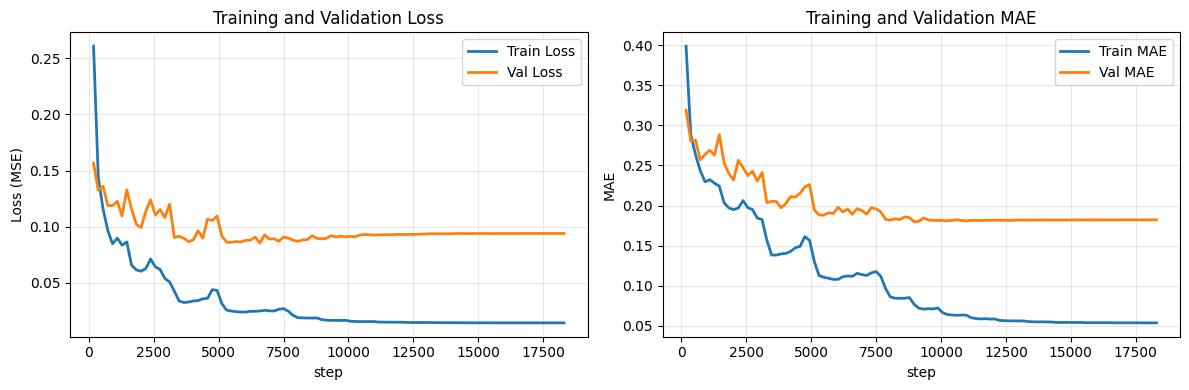


Final metrics:
Train Loss: 0.0141
Val Loss: 0.0939
Train MAE: 0.0538
Val MAE: 0.1822


In [17]:
from src.models.metrics import get_curves_and_metrics_from_tb_logs

get_curves_and_metrics_from_tb_logs(LOG_DIR=resolve_path("./tb_logs/best_MLP_model"))

# Load best model as pipeline for using encoder

In [18]:
# load best model as pipeline for using encoder
best_pipeline = Pipeline.load_from_checkpoint(
    checkpoint_path=checkpoint_callback.best_model_path,
    model_cls=MLP,
    inv_transform_y=inv_transform,
)
best_pipeline.eval()

Seed set to 42


Pipeline(
  (model): MLP(
    (latent_embedder): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.0, inplace=False)
      (6): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (7): Linear(in_features=64, out_features=32, bias=True)
    )
    (regressor): Sequential(
      (0): ReLU()
      (1): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (criterion): MSELoss()
)

# Collect train latents

In [19]:
# Collect latents
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_latents = collect_latents(best_pipeline, train_dataloader, device)

# Calculate statistics on train in latent space

In [20]:
# Calculate statistics
mean, cov, cov_inv = get_mean_cov_scipy(train_latents)
df = train_latents.shape[1]

# Calculate Mahalanobis distances for train in latent space

In [21]:
# Mahalanobis distances
train_md = mahalanobis_batch(train_latents, mean, cov_inv)

In [22]:
train_md.mean()

np.float64(16.82223378495645)

# CvM test for normality of latent space

In [23]:
# CvM test
stat, pvalue, passed = cvm_test_chi2(train_md, df)
print(f"CvM statistic: {stat}")
print(f"p-value: {pvalue}")
print(f"Normality passed: {passed}")

CvM statistic: 2952.285833941225
p-value: 4.2361070640151155e-07
Normality passed: False


# Threshold for applicability domain

In [24]:
# Threshold
if passed:
    threshold = chi2_threshold(df, alpha=0.95)
else:
    threshold = np.percentile(train_md, 95)

print(f"Threshold: {threshold:.4f}")

Threshold: 31.6707


# Rejection rate on validation

In [25]:
val_rej = rejection_rate_scipy(
    pipeline=best_pipeline, 
    val_dataloader=val_dataloader, 
    mean=mean, 
    cov_inv=cov_inv, 
    threshold=threshold,
    device=device,
)

print(f"Rejection rate on validation: {val_rej:.4f}")

Rejection rate on validation: 0.0500


# Evaluate model on test

In [26]:
# Evaluate model on test
print("Evaluating model...")
test_results = trainer.test(ckpt_path="best", dataloaders=test_dataloader)

Restoring states from the checkpoint path at /home/palko-wsl-ubuntu/projects/kaggle-chemical-structure-and-logp/tb_logs/best_MLP_model/version_0/checkpoints/epoch=48-val_mae=0.1798.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/palko-wsl-ubuntu/projects/kaggle-chemical-structure-and-logp/tb_logs/best_MLP_model/version_0/checkpoints/epoch=48-val_mae=0.1798.ckpt
/home/palko-wsl-ubuntu/projects/kaggle-chemical-structure-and-logp/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Evaluating model...
Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 114.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            0.18557719886302948
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [27]:
print(f"Test MAE: {test_results[0]['test_mae']}")

Test MAE: 0.18557719886302948


# Rejection rate on test

In [28]:
test_rej = rejection_rate_scipy(
    pipeline=best_pipeline, 
    val_dataloader=test_dataloader, 
    mean=mean, 
    cov_inv=cov_inv, 
    threshold=threshold,
    device=device,
)

print(f"Rejection rate on test: {test_rej:.4f}")

Rejection rate on test: 0.0465


# Plot mahalonobis distributions for train, val, test

In [29]:
val_latents = collect_latents(best_pipeline, val_dataloader, device)
val_md = mahalanobis_batch(val_latents, mean, cov_inv)

test_latents = collect_latents(best_pipeline, test_dataloader, device)
test_md = mahalanobis_batch(test_latents, mean, cov_inv)

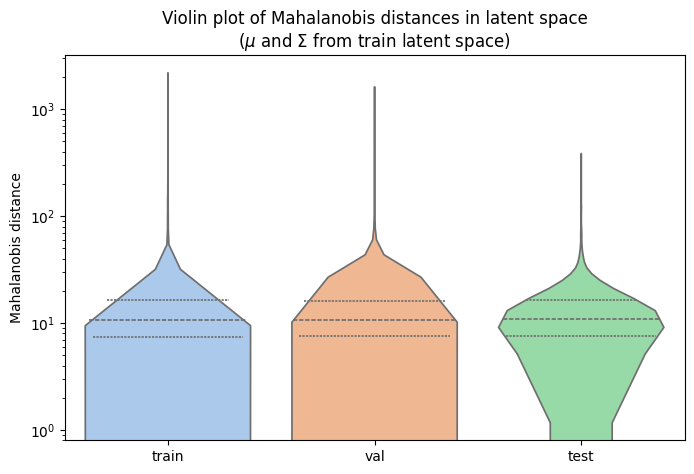

In [30]:
plot_mahalanobis_distributions(train_md=train_md, val_md=val_md, test_md=test_md, log_scale=True)

# Run Genetic algorithm for maximizing LogP 

In [31]:
# sample initial population
random.seed(42)
initial_population = random.sample(
    data["smiles"].iloc[split_info["train"]].tolist(),
    2000,
)

In [32]:
# Calculate thresholds
d95 = threshold
k = 8 # adjusted_fitness(d_threshold) = fitness / k
alpha = np.log(k) / (d95**2)

print(f"95th percentile distance: {d95}")
print(f"Alpha parameter: {alpha}")

95th percentile distance: 31.670691163524225
Alpha parameter: 0.0020731543305436096


In [33]:
# run genetic algorithm
random.seed(42)
history, final_population = run_ga(
    init_smiles_list=initial_population,
    pipeline=best_pipeline,
    inv_transform=inv_transform,
    mean=mean,
    cov_inv=cov_inv,
    d95=d95,
    alpha=alpha,
    device=device,
    pop_size=2000,
    n_generations=100,
    mutants_per_parent=5,
    elite_frac=0.2,
    hard_ad_cut_every=20,
    maximize=True,
)


=== GEN 0 ===
Best adj fitness=2.3717 | pred=2.507 | d=5.17
SMILES: C[C](C)CCCCl


[02:29:21] WARNING: not removing hydrogen atom without neighbors
[02:29:21] WARNING: not removing hydrogen atom without neighbors
[02:29:22] WARNING: not removing hydrogen atom without neighbors
[02:29:22] WARNING: not removing hydrogen atom without neighbors
[02:29:22] WARNING: not removing hydrogen atom without neighbors



=== GEN 1 ===
Best adj fitness=2.3864 | pred=2.662 | d=7.26
SMILES: CC(C)CCCCl


[02:29:32] WARNING: not removing hydrogen atom without neighbors
[02:29:32] WARNING: not removing hydrogen atom without neighbors
[02:29:32] WARNING: not removing hydrogen atom without neighbors



=== GEN 2 ===
Best adj fitness=2.3998 | pred=2.603 | d=6.27
SMILES: ClCCCC(C)(C)C


[02:29:40] WARNING: not removing hydrogen atom without neighbors



=== GEN 3 ===
Best adj fitness=2.3240 | pred=2.539 | d=6.53
SMILES: S(Cl)(Cl)Cl


[02:29:47] WARNING: not removing hydrogen atom without neighbors
[02:29:47] WARNING: not removing hydrogen atom without neighbors
[02:29:48] WARNING: not removing hydrogen atom without neighbors



=== GEN 4 ===
Best adj fitness=2.3070 | pred=2.463 | d=5.62
SMILES: CCCSCCl


[02:29:55] WARNING: not removing hydrogen atom without neighbors
[02:29:55] WARNING: not removing hydrogen atom without neighbors



=== GEN 5 ===
Best adj fitness=2.3848 | pred=2.526 | d=5.26
SMILES: BrC#CC#P=PCl


[02:30:03] WARNING: not removing hydrogen atom without neighbors
[02:30:03] WARNING: not removing hydrogen atom without neighbors
[02:30:03] WARNING: not removing hydrogen atom without neighbors
[02:30:03] WARNING: not removing hydrogen atom without neighbors
[02:30:03] WARNING: not removing hydrogen atom without neighbors
[02:30:03] WARNING: not removing hydrogen atom without neighbors



=== GEN 6 ===
Best adj fitness=2.3962 | pred=2.737 | d=8.01
SMILES: BrCC#P=PCl

=== GEN 7 ===
Best adj fitness=2.3428 | pred=2.651 | d=7.72
SMILES: ClCSCC[14CH2]Br


[02:30:17] WARNING: not removing hydrogen atom without neighbors



=== GEN 8 ===
Best adj fitness=2.3553 | pred=2.939 | d=10.34
SMILES: BrP=PCl


[02:30:24] WARNING: not removing hydrogen atom without neighbors



=== GEN 9 ===
Best adj fitness=2.3439 | pred=2.576 | d=6.75
SMILES: ICC=CSC

=== GEN 10 ===
Best adj fitness=2.2862 | pred=2.405 | d=4.94
SMILES: CCCC#PBr


[02:30:39] WARNING: not removing hydrogen atom without neighbors
[02:30:39] WARNING: not removing hydrogen atom without neighbors
[02:30:39] WARNING: not removing hydrogen atom without neighbors
[02:30:39] WARNING: not removing hydrogen atom without neighbors
[02:30:39] WARNING: not removing hydrogen atom without neighbors
[02:30:39] WARNING: not removing hydrogen atom without neighbors



=== GEN 11 ===
Best adj fitness=2.3907 | pred=2.725 | d=7.95
SMILES: C#P(Cl)CCl


[02:30:48] WARNING: not removing hydrogen atom without neighbors
[02:30:48] WARNING: not removing hydrogen atom without neighbors
[02:30:48] WARNING: not removing hydrogen atom without neighbors



=== GEN 12 ===
Best adj fitness=2.3317 | pred=2.645 | d=7.79
SMILES: FC=SC(C)CSCl

=== GEN 13 ===
Best adj fitness=2.4242 | pred=2.667 | d=6.79
SMILES: FC=SC(C)CSCCl


[02:31:07] WARNING: not removing hydrogen atom without neighbors
[02:31:07] WARNING: not removing hydrogen atom without neighbors



=== GEN 14 ===
Best adj fitness=2.3428 | pred=2.651 | d=7.72
SMILES: ClCSCCCBr


[02:31:16] WARNING: not removing hydrogen atom without neighbors
[02:31:16] WARNING: not removing hydrogen atom without neighbors



=== GEN 15 ===
Best adj fitness=2.4490 | pred=2.864 | d=8.69
SMILES: BrC=C=PBr


[02:31:23] WARNING: not removing hydrogen atom without neighbors
[02:31:24] WARNING: not removing hydrogen atom without neighbors
[02:31:24] WARNING: not removing hydrogen atom without neighbors
[02:31:24] WARNING: not removing hydrogen atom without neighbors



=== GEN 16 ===
Best adj fitness=2.3470 | pred=2.482 | d=5.19
SMILES: BrCPCCl


[02:31:32] WARNING: not removing hydrogen atom without neighbors
[02:31:32] WARNING: not removing hydrogen atom without neighbors
[02:31:32] WARNING: not removing hydrogen atom without neighbors
[02:31:33] WARNING: not removing hydrogen atom without neighbors



=== GEN 17 ===
Best adj fitness=2.5120 | pred=2.775 | d=6.93
SMILES: ClCCC(C)CC=CCl

=== GEN 18 ===
Best adj fitness=2.5120 | pred=2.775 | d=6.93
SMILES: ClCCC(C)CC=CCl

=== GEN 19 ===
Best adj fitness=2.5120 | pred=2.775 | d=6.93
SMILES: ClCCC(C)CC=CCl


[02:31:55] WARNING: not removing hydrogen atom without neighbors



=== GEN 20 ===
Best adj fitness=2.3470 | pred=2.482 | d=5.19
SMILES: ClCPCBr

=== GEN 21 ===
Best adj fitness=2.3864 | pred=2.662 | d=7.26
SMILES: ClCCCC(C)C


[02:32:13] WARNING: not removing hydrogen atom without neighbors



=== GEN 22 ===
Best adj fitness=2.3470 | pred=2.482 | d=5.19
SMILES: ClCPCBr


[02:32:20] WARNING: not removing hydrogen atom without neighbors
[02:32:20] WARNING: not removing hydrogen atom without neighbors



=== GEN 23 ===
Best adj fitness=2.3428 | pred=2.651 | d=7.72
SMILES: ClCSCCCBr


[02:32:28] WARNING: not removing hydrogen atom without neighbors



=== GEN 24 ===
Best adj fitness=2.3452 | pred=2.568 | d=6.61
SMILES: ClC#P(F)Cl


[02:32:36] WARNING: not removing hydrogen atom without neighbors
[02:32:37] WARNING: not removing hydrogen atom without neighbors



=== GEN 25 ===
Best adj fitness=2.4124 | pred=2.646 | d=6.68
SMILES: ClC#PBr


[02:32:44] WARNING: not removing hydrogen atom without neighbors
[02:32:44] WARNING: not removing hydrogen atom without neighbors



=== GEN 26 ===
Best adj fitness=2.4124 | pred=2.646 | d=6.68
SMILES: ClC#PBr


[02:32:52] WARNING: not removing hydrogen atom without neighbors
[02:32:52] WARNING: not removing hydrogen atom without neighbors



=== GEN 27 ===
Best adj fitness=2.4124 | pred=2.646 | d=6.68
SMILES: ClC#PBr


[02:32:59] WARNING: not removing hydrogen atom without neighbors



=== GEN 28 ===
Best adj fitness=2.4245 | pred=2.672 | d=6.85
SMILES: CC#CC=CCCPCl


[02:33:07] WARNING: not removing hydrogen atom without neighbors
[02:33:07] WARNING: not removing hydrogen atom without neighbors



=== GEN 29 ===
Best adj fitness=2.2959 | pred=2.400 | d=4.62
SMILES: [H]C#CC=CPBr


[02:33:16] WARNING: not removing hydrogen atom without neighbors



=== GEN 30 ===
Best adj fitness=2.3167 | pred=2.810 | d=9.65
SMILES: CSC[C@H1]=CCCPCl


[02:33:24] WARNING: not removing hydrogen atom without neighbors
[02:33:24] WARNING: not removing hydrogen atom without neighbors
[02:33:24] WARNING: not removing hydrogen atom without neighbors



=== GEN 31 ===
Best adj fitness=2.4265 | pred=2.689 | d=7.03
SMILES: C#CC=CCCPCl

=== GEN 32 ===
Best adj fitness=2.4124 | pred=2.646 | d=6.68
SMILES: ClC#PBr

=== GEN 33 ===
Best adj fitness=2.4124 | pred=2.646 | d=6.68
SMILES: ClC#PBr

=== GEN 34 ===
Best adj fitness=2.3283 | pred=2.463 | d=5.21
SMILES: CSCC=CS=PCl

=== GEN 35 ===
Best adj fitness=2.3596 | pred=2.597 | d=6.80
SMILES: CCC=CCCPCl

=== GEN 36 ===
Best adj fitness=2.4359 | pred=2.722 | d=7.32
SMILES: C(C)CC#SC#PBr

=== GEN 37 ===
Best adj fitness=2.4359 | pred=2.722 | d=7.32
SMILES: C(C)CC#SC#PBr

=== GEN 38 ===
Best adj fitness=2.4359 | pred=2.722 | d=7.32
SMILES: CCCC#SC#PBr


[02:34:28] WARNING: not removing hydrogen atom without neighbors



=== GEN 39 ===
Best adj fitness=2.3624 | pred=2.529 | d=5.74
SMILES: ClP#CSBr

=== GEN 40 ===
Best adj fitness=2.3414 | pred=2.585 | d=6.90
SMILES: CC=CCCPCl

=== GEN 41 ===
Best adj fitness=2.3914 | pred=2.493 | d=4.48
SMILES: C=CCCPCl

=== GEN 42 ===
Best adj fitness=2.4053 | pred=2.727 | d=7.79
SMILES: BrC#CCPCBr

=== GEN 43 ===
Best adj fitness=2.3914 | pred=2.493 | d=4.48
SMILES: C=CCCPCl


[02:35:11] WARNING: not removing hydrogen atom without neighbors



=== GEN 44 ===
Best adj fitness=2.2901 | pred=2.435 | d=5.44
SMILES: CC#CCS[C@H1]=CCl

=== GEN 45 ===
Best adj fitness=2.2874 | pred=2.617 | d=8.05
SMILES: CC#CCSC=CC

=== GEN 46 ===
Best adj fitness=2.3573 | pred=2.848 | d=9.55
SMILES: CC=SC#PBr

=== GEN 47 ===
Best adj fitness=2.3573 | pred=2.848 | d=9.55
SMILES: CC=SC#PBr

=== GEN 48 ===
Best adj fitness=2.2951 | pred=2.531 | d=6.87
SMILES: S(C)C=CC=BBr


[02:35:51] WARNING: not removing hydrogen atom without neighbors
[02:35:51] WARNING: not removing hydrogen atom without neighbors



=== GEN 49 ===
Best adj fitness=2.2951 | pred=2.531 | d=6.87
SMILES: S(C)C=CC=BBr


[02:36:00] WARNING: not removing hydrogen atom without neighbors
[02:36:00] WARNING: not removing hydrogen atom without neighbors



=== GEN 50 ===
Best adj fitness=2.4124 | pred=2.646 | d=6.68
SMILES: BrP#CCl

=== GEN 51 ===
Best adj fitness=2.2857 | pred=2.618 | d=8.09
SMILES: C(C)P=P#C

=== GEN 52 ===
Best adj fitness=2.3380 | pred=2.666 | d=7.96
SMILES: C(C)C=CS=BBr

=== GEN 53 ===
Best adj fitness=2.4071 | pred=2.709 | d=7.55
SMILES: C=BCCCCC=BBr


[02:36:31] WARNING: not removing hydrogen atom without neighbors
[02:36:31] WARNING: not removing hydrogen atom without neighbors



=== GEN 54 ===
Best adj fitness=2.3624 | pred=2.529 | d=5.74
SMILES: BrSC#PCl

=== GEN 55 ===
Best adj fitness=2.3624 | pred=2.529 | d=5.74
SMILES: BrSC#PCl


[02:36:48] WARNING: not removing hydrogen atom without neighbors



=== GEN 56 ===
Best adj fitness=2.3416 | pred=2.785 | d=9.15
SMILES: S(CCC=C)CSBr

=== GEN 57 ===
Best adj fitness=2.3180 | pred=2.475 | d=5.63
SMILES: CC=CC#PBr

=== GEN 58 ===
Best adj fitness=2.4945 | pred=2.739 | d=6.72
SMILES: CC#CCC(C)CBr

=== GEN 59 ===
Best adj fitness=2.3953 | pred=2.660 | d=7.11
SMILES: BrP=POCl


[02:37:20] WARNING: not removing hydrogen atom without neighbors



=== GEN 60 ===
Best adj fitness=2.3553 | pred=2.939 | d=10.34
SMILES: BrP=PCl

=== GEN 61 ===
Best adj fitness=2.4945 | pred=2.739 | d=6.72
SMILES: CC#CCC(C)CBr

=== GEN 62 ===
Best adj fitness=2.3964 | pred=2.793 | d=8.60
SMILES: CCC(C)(C)CSBr


[02:37:45] WARNING: not removing hydrogen atom without neighbors
[02:37:45] WARNING: not removing hydrogen atom without neighbors



=== GEN 63 ===
Best adj fitness=2.3964 | pred=2.793 | d=8.60
SMILES: CCC(C)(C)CSBr

=== GEN 64 ===
Best adj fitness=2.3055 | pred=2.665 | d=8.36
SMILES: C=CC(C)CC=CN=BBr

=== GEN 65 ===
Best adj fitness=2.3841 | pred=2.675 | d=7.45
SMILES: CCC([H])CC=CS=SBr

=== GEN 66 ===
Best adj fitness=2.3841 | pred=2.675 | d=7.45
SMILES: CCC([H])CC=CS=SBr

=== GEN 67 ===
Best adj fitness=2.4436 | pred=2.650 | d=6.25
SMILES: CCCCSC=CS=P#CS=P


[02:38:24] WARNING: not removing hydrogen atom without neighbors
[02:38:24] WARNING: not removing hydrogen atom without neighbors
[02:38:25] WARNING: not removing hydrogen atom without neighbors



=== GEN 68 ===
Best adj fitness=2.4490 | pred=2.864 | d=8.69
SMILES: BrP=C=CBr


[02:38:32] WARNING: not removing hydrogen atom without neighbors



=== GEN 69 ===
Best adj fitness=2.4100 | pred=2.700 | d=7.41
SMILES: O(C)C=P=PBr


[02:38:39] WARNING: not removing hydrogen atom without neighbors
[02:38:39] WARNING: not removing hydrogen atom without neighbors
[02:38:39] WARNING: not removing hydrogen atom without neighbors



=== GEN 70 ===
Best adj fitness=2.3802 | pred=2.598 | d=6.49
SMILES: C(C)CCSC=CS=PF


[02:38:47] WARNING: not removing hydrogen atom without neighbors
[02:38:47] WARNING: not removing hydrogen atom without neighbors



=== GEN 71 ===
Best adj fitness=2.3292 | pred=2.590 | d=7.15
SMILES: CSC=CS=PBr


[02:38:55] WARNING: not removing hydrogen atom without neighbors



=== GEN 72 ===
Best adj fitness=2.4100 | pred=2.700 | d=7.41
SMILES: O(C)C=P=PBr

=== GEN 73 ===
Best adj fitness=2.4100 | pred=2.700 | d=7.41
SMILES: O(C)C=P=PBr


[02:39:09] WARNING: not removing hydrogen atom without neighbors



=== GEN 74 ===
Best adj fitness=2.3964 | pred=2.793 | d=8.60
SMILES: CCC(C)(C)CSBr


[02:39:17] WARNING: not removing hydrogen atom without neighbors
[02:39:17] WARNING: not removing hydrogen atom without neighbors
[02:39:17] WARNING: not removing hydrogen atom without neighbors



=== GEN 75 ===
Best adj fitness=2.3899 | pred=2.468 | d=3.95
SMILES: CSCP#PBr

=== GEN 76 ===
Best adj fitness=2.4490 | pred=2.864 | d=8.69
SMILES: BrC=C=PBr


[02:39:33] WARNING: not removing hydrogen atom without neighbors



=== GEN 77 ===
Best adj fitness=2.4490 | pred=2.864 | d=8.69
SMILES: BrC=C=PBr


[02:39:40] WARNING: not removing hydrogen atom without neighbors
[02:39:40] WARNING: not removing hydrogen atom without neighbors



=== GEN 78 ===
Best adj fitness=2.4451 | pred=2.753 | d=7.56
SMILES: CCCC(C)CCS#CF


[02:39:48] WARNING: not removing hydrogen atom without neighbors
[02:39:48] WARNING: not removing hydrogen atom without neighbors
[02:39:48] WARNING: not removing hydrogen atom without neighbors



=== GEN 79 ===
Best adj fitness=2.4451 | pred=2.753 | d=7.56
SMILES: CCCC(C)CCS#CF


[02:39:56] WARNING: not removing hydrogen atom without neighbors
[02:39:56] WARNING: not removing hydrogen atom without neighbors
[02:39:56] WARNING: not removing hydrogen atom without neighbors



=== GEN 80 ===
Best adj fitness=2.3841 | pred=2.675 | d=7.45
SMILES: CCCCC=CS=SBr


[02:40:03] WARNING: not removing hydrogen atom without neighbors



=== GEN 81 ===
Best adj fitness=2.4862 | pred=2.818 | d=7.77
SMILES: BrC=C=C=PBr

=== GEN 82 ===
Best adj fitness=2.4490 | pred=2.864 | d=8.69
SMILES: BrC=C=PBr

=== GEN 83 ===
Best adj fitness=2.4490 | pred=2.864 | d=8.69
SMILES: BrC=C=PBr


[02:40:29] WARNING: not removing hydrogen atom without neighbors



=== GEN 84 ===
Best adj fitness=2.3292 | pred=2.590 | d=7.15
SMILES: S(C)C=CS=PBr


[02:40:37] WARNING: not removing hydrogen atom without neighbors



=== GEN 85 ===
Best adj fitness=2.4490 | pred=2.864 | d=8.69
SMILES: BrC=C=PBr

=== GEN 86 ===
Best adj fitness=2.4490 | pred=2.864 | d=8.69
SMILES: BrC=C=PBr

=== GEN 87 ===
Best adj fitness=2.4490 | pred=2.864 | d=8.69
SMILES: BrC=C=PBr

=== GEN 88 ===
Best adj fitness=2.3511 | pred=2.549 | d=6.25
SMILES: C=CCC=CS=SBr

=== GEN 89 ===
Best adj fitness=2.3696 | pred=2.585 | d=6.48
SMILES: CCC(C)C=CSC#B

=== GEN 90 ===
Best adj fitness=2.4889 | pred=2.800 | d=7.53
SMILES: CCC(C)CB=CC#S=C=BBr

=== GEN 91 ===
Best adj fitness=2.4442 | pred=2.627 | d=5.90
SMILES: CCC(C)CSC#B

=== GEN 92 ===
Best adj fitness=2.3478 | pred=2.483 | d=5.20
SMILES: CC(CC=CC)CCl

=== GEN 93 ===
Best adj fitness=2.3775 | pred=2.818 | d=9.06
SMILES: C(C)CC#SSS=P=S

=== GEN 94 ===
Best adj fitness=2.4442 | pred=2.627 | d=5.90
SMILES: CCC(C)CSC#B

=== GEN 95 ===
Best adj fitness=2.4442 | pred=2.627 | d=5.90
SMILES: CCC(C)CSC#B


[02:42:03] WARNING: not removing hydrogen atom without neighbors



=== GEN 96 ===
Best adj fitness=2.4442 | pred=2.627 | d=5.90
SMILES: CCC(C)CSC#B


[02:42:10] WARNING: not removing hydrogen atom without neighbors



=== GEN 97 ===
Best adj fitness=2.3166 | pred=2.477 | d=5.68
SMILES: C#CCC=CS=PC#P

=== GEN 98 ===
Best adj fitness=2.3477 | pred=2.659 | d=7.75
SMILES: CC(C)CC=C=C=BBr

=== GEN 99 ===
Best adj fitness=2.3816 | pred=2.636 | d=6.99
SMILES: CCCB=C=S=CSBr


[02:42:33] WARNING: not removing hydrogen atom without neighbors
[02:42:33] WARNING: not removing hydrogen atom without neighbors


In [34]:
# how much smiles from initial population survived in final population
intersection_smiles = list(
    set(final_population).intersection(
        set(data["smiles"].to_list())
    )
)

print(f"size of final_population: {len(final_population)}")
print(f"number of shared smiles in initial and final population: {len(intersection_smiles)}")
print("\nshared smiles:",*intersection_smiles,sep="\n")

size of final_population: 1111
number of shared smiles in initial and final population: 52

shared smiles:
CCCCSPCl
CCCCBr
CCI
CC(C)CCF
CCCCC=O
CC(=C)CBr
CCCSC=C
CPBr
CCCCS
CC=CPC
CCCSS
CCC=CCl
CPCBr
CCCPCl
CCCC=CBr
CSC=CBr
CI
CC=CBr
CCC(C)Cl
CCCCCSC
CCCCCl
CCCSC
CCCC=CCl
CCBr
CCCCCC=C
C=CCI
CCCSCl
CCCC=CC
CC=CCS
CC=CSC
CC=CCBr
CCCC=P
CPCl
CPCCCl
CCCCSCl
CCSBr
CCC=CBr
C=CSBr
CCCNCl
CCCCSCCl
CCCSCCl
CSSF
C=CPSF
CCC=CS
CCCBr
C#CBr
CCCCCCl
C=CBr
CCCCC=S
CCSCl
CCC=CCBr
CBr


In [35]:
final_population = list(
    filter(lambda smi: smi not in intersection_smiles, final_population)
)

print(f"initial population smiles removed from final population.")
print(f"size of final population after filtration: {len(final_population)}")

initial population smiles removed from final population.
size of final population after filtration: 1059


In [36]:
# calculate logp
initial_logp = []
for smi in initial_population:
    pred = predict_logp(smi, best_pipeline, inv_transform, device)
    if pred is not None:
        initial_logp.append(pred)

final_logp = []
for smi in final_population:
    pred = predict_logp(smi, best_pipeline, inv_transform, device)
    if pred is not None:
        final_logp.append(pred)

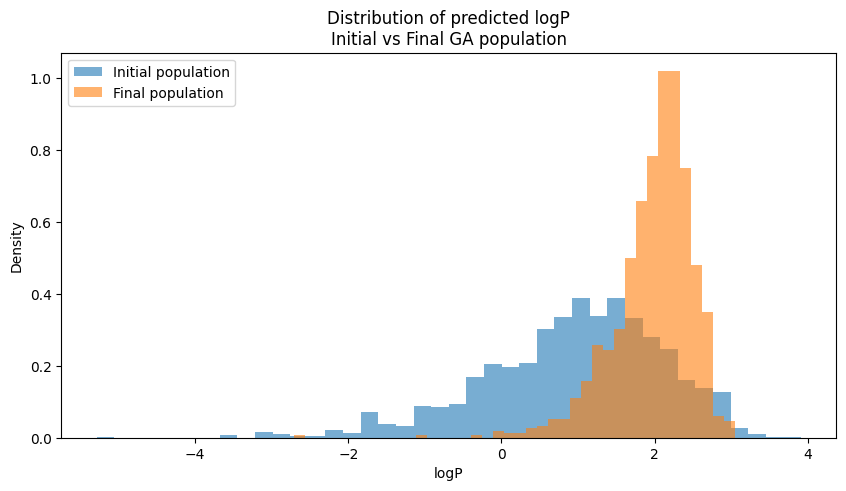

In [37]:
plot_logp_comparison(initial_logp, final_logp)

SMILES: C=BCC=CSC
Predicted LogP: 2.07
Crippen rdkit LogP: 1.42


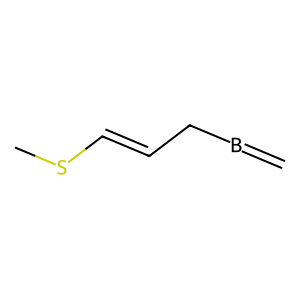

SMILES: CS#S=CC#SCC=CPBr
Predicted LogP: 2.63
Crippen rdkit LogP: 3.73


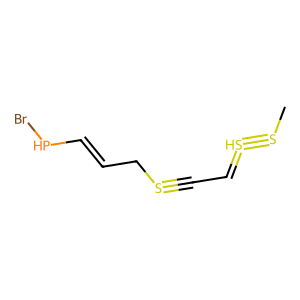

SMILES: CC#S#CC=CC
Predicted LogP: 1.87
Crippen rdkit LogP: 2.23


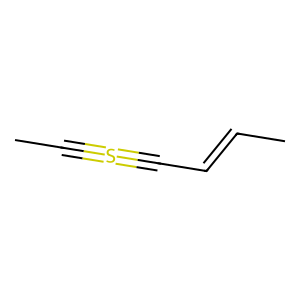

SMILES: C=CS=BS=PC#N
Predicted LogP: 2.34
Crippen rdkit LogP: 1.29


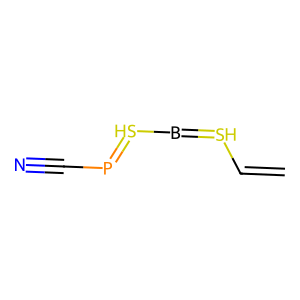

SMILES: CC=C=CC=C=BSSBr
Predicted LogP: 2.19
Crippen rdkit LogP: 2.99


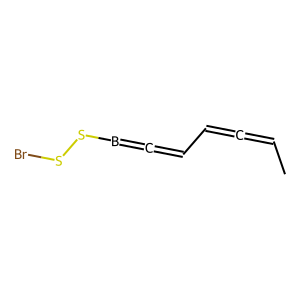

SMILES: C=CCC=CCBr
Predicted LogP: 2.28
Crippen rdkit LogP: 2.51


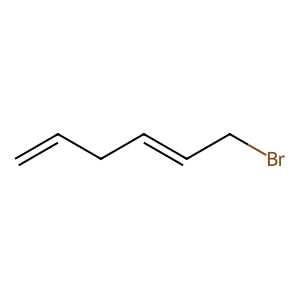

SMILES: CC=C=C=CCl
Predicted LogP: 2.10
Crippen rdkit LogP: 2.07


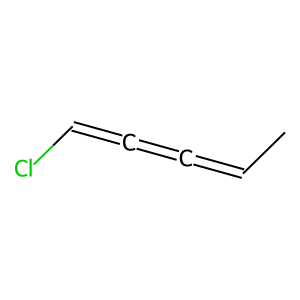

SMILES: C=CS=SBr
Predicted LogP: 2.42
Crippen rdkit LogP: 0.98


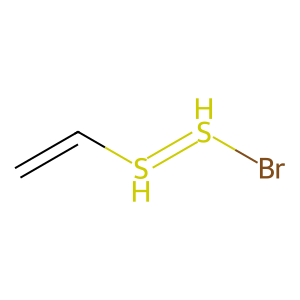

In [38]:
from IPython.display import display
from rdkit.Chem.Crippen import MolLogP

random.seed(42)
idx_final_population_smiles_to_draw = random.sample(
    [idx for idx in range(len(final_population))],
    8,
)

for idx in idx_final_population_smiles_to_draw:
    smi = final_population[idx]
    m = Chem.MolFromSmiles(smi)
    mol_img = Chem.Draw.MolToImage(m)

    rdkit_logp = MolLogP(m)

    print(f"SMILES: {smi}")
    print(f"Predicted LogP: {final_logp[idx]:.2f}")
    print(f"Crippen rdkit LogP: {rdkit_logp:.2f}")

    display(mol_img)

In [39]:
final_logp_rdkit = [MolLogP(Chem.MolFromSmiles(smi)) for smi in final_population]

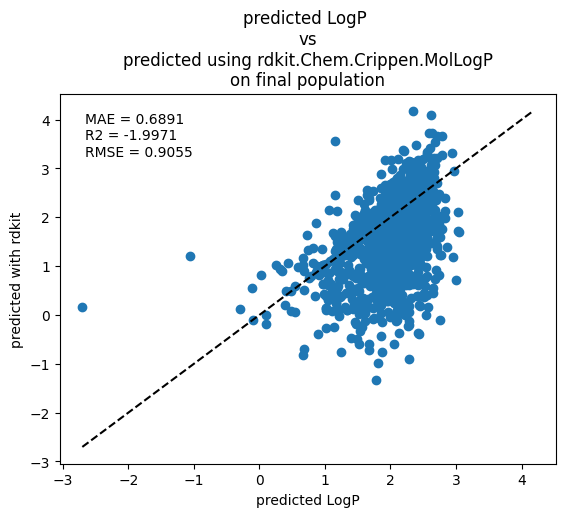

MAE = 0.6891
R2 = -1.9971
RMSE = 0.9055



In [40]:
parity_plot(
    y_1=np.array(final_logp), 
    y_2=np.array(final_logp_rdkit), 
    title="predicted LogP \nvs\npredicted using rdkit.Chem.Crippen.MolLogP\non final population",
    xlabel="predicted LogP",
    ylabel="predicted with rdkit",
)

# Conclusion

We have tuned and fitted MLP regressor for predicting logp (which was calculated using rdkit.Chem.Crippen.MolLogP).

After that, applicability domain threshold for mahalonobis distance in latent space was established for MLP regressor based on train subset.

Both val and test subsets are generally inside applicability domain of MLP model (with rejection rate ~ 0.05).
Though train latent space didnt passed normality test which may be due to sparsity of fingerprints. We can see that distribution of machalonobis distances is very narrow.

After running genetic algorithm we can see distribution shift for logp predicted by MLP regressor.

In addition to that, we can look at random examples from final population and can see there generally oleophillic molecules. Definitely our model learned that length of carbon chains correlates with LogP.

Though, parity plot between MLP Regressor predictions and rdkit.Chem.Crippen.MolLogP predictions on final population display poor consistency. But main trend can be recognized.   